## Importing dependencies

In [1]:
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from gym_anytrading.datasets import STOCKS_GOOGL
import itertools
import warnings
import statsmodels.api as sm
import datetime
from statsmodels.tsa.arima_model import ARIMA

## RL dependencies

In [2]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


## Processing dependencies

In [3]:
import numpy as np
import pandas as pnd
from matplotlib import pyplot as plt

In [4]:
df = pnd.read_csv('datasets/AAPL.csv')
df.head()

,date,volume,open,close,high,low,adjclose
0,2018-11-02,91263400,209.550003,207.479996,213.649994,205.429993,207.479996
1,2018-11-01,58323200,219.050003,222.220001,222.360001,216.809998,222.220001
2,2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995,218.860001
3,2018-10-30,36660000,211.149994,213.300003,215.179993,209.270004,213.300003
4,2018-10-29,45935500,219.190002,212.240005,219.690002,206.089996,212.240005


In [5]:
df['date'] = pnd.to_datetime(df['date'], format='%Y-%m-%d')
df.dtypes

date        datetime64[ns]
volume               int64
open               float64
close              float64
high               float64
low                float64
adjclose           float64
dtype: object

In [6]:
df.isnull().sum()

date        0
volume      0
open        0
close       0
high        0
low         0
adjclose    0
dtype: int64

In [7]:
df.sort_values('date', ascending=True, inplace=True)
df.head()

,date,volume,open,close,high,low,adjclose
9555,1980-12-12,117258400,0.513393,0.513393,0.515625,0.513393,0.023186
9554,1980-12-15,43971200,0.488839,0.486607,0.488839,0.486607,0.021977
9553,1980-12-16,26432000,0.453125,0.450893,0.453125,0.450893,0.020364
9552,1980-12-17,21610400,0.462054,0.462054,0.464286,0.462054,0.020868
9551,1980-12-18,18362400,0.475446,0.475446,0.477679,0.475446,0.021473


In [8]:
df.set_index('date', inplace=True)

In [9]:
df.drop(columns=['adjclose'], inplace=True)

In [10]:
df.tail()

,volume,open,close,high,low
date,,,,,
2018-10-29,45935500,219.190002,212.240005,219.690002,206.089996
2018-10-30,36660000,211.149994,213.300003,215.179993,209.270004
2018-10-31,38358900,216.880005,218.860001,220.449997,216.619995
2018-11-01,58323200,219.050003,222.220001,222.360001,216.809998
2018-11-02,91263400,209.550003,207.479996,213.649994,205.429993


In [11]:
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2020,1,1)

### Preparing close set

In [12]:
train_data_close = df['2000-01-01':'2015-01-01']
train_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
test_data_close = df['2015-01-02':'2020-01-01']
test_data_close.drop(columns=['open', 'high', 'volume', 'low'], inplace=True)
print('test_data_close length: ', len(test_data_close), 'train_data_close length:', len(train_data_close), 'whole set:', len(df))
train_data_close.tail()

test_data_close length:  968 train_data_close length: 3773 whole set: 9556


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,close
date,
2014-12-24,112.010002
2014-12-26,113.989998
2014-12-29,113.910004
2014-12-30,112.519997
2014-12-31,110.379997


### Preparing low set

In [13]:
train_data_low = df['2000-01-01':'2015-01-01']
train_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
test_data_low = df['2015-01-02':'2020-01-01']
test_data_low.drop(columns=['open', 'high','volume', 'close'], inplace=True)
print('test_data_low length: ', len(test_data_low), 'train_data_low length:', len(train_data_low), 'whole set:', len(df))
train_data_low.tail()

test_data_low length:  968 train_data_low length: 3773 whole set: 9556


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,low
date,
2014-12-24,112.010002
2014-12-26,112.010002
2014-12-29,113.699997
2014-12-30,112.110001
2014-12-31,110.209999


### Preparing high set

In [14]:
train_data_high = df['2000-01-01':'2015-01-01']
train_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
test_data_high = df['2015-01-02':'2020-01-01']
test_data_high.drop(columns=['open', 'low','volume', 'close'], inplace=True)
print('test_data_high length: ', len(test_data_high), 'train_data_high length:', len(train_data_high), 'whole set:', len(df))
train_data_high.tail()

test_data_high length:  968 train_data_high length: 3773 whole set: 9556


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,high
date,
2014-12-24,112.709999
2014-12-26,114.519997
2014-12-29,114.769997
2014-12-30,113.919998
2014-12-31,113.129997


### Preparing open set

In [15]:
train_data_open = df['2000-01-01':'2015-01-01']
train_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
test_data_open = df['2015-01-02':'2020-01-01']
test_data_open.drop(columns=['high', 'low','volume', 'close'], inplace=True)
print('test_data_open length: ', len(test_data_open), 'train_data_open length:', len(train_data_open), 'whole set:', len(df))
train_data_open.tail()

test_data_open length:  968 train_data_open length: 3773 whole set: 9556


/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open
date,
2014-12-24,112.580002
2014-12-26,112.099998
2014-12-29,113.790001
2014-12-30,113.639999
2014-12-31,112.820000


## ARIMA Model

### ARIMA for close

In [16]:
mod_close = ARIMA(train_data_close,order=(3,2,1))
results_close = mod_close.fit(disp=-1)

/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been pr

### ARIMA for open

In [17]:
mod_open = ARIMA(train_data_open,order=(3,1,1))
results_open = mod_open.fit(disp=-1)

/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of 

### ARIMA for low

In [18]:
mod_low = ARIMA(train_data_low,order=(3,1,1))
results_low = mod_low.fit(disp=-1)

/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of 

### ARIMA for high

In [19]:
mod_high = ARIMA(train_data_high,order=(3,2,1))
results_high = mod_high.fit(disp=-1)

/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/dippy/Studies/dl_diploma/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of 

## ARIMA Prediction

### Close ARIMA

In [20]:
index = pnd.date_range(start_date,end_date)
pred,se,conf = results_close.forecast(len(index), alpha=0.1)
fc_series_close = pnd.Series(pred, index=index)
lower_series_close = pnd.Series(conf[:, 0], index=index)
upper_series_close = pnd.Series(conf[:, 1], index=index)

### Open ARIMA

In [21]:
index = pnd.date_range(start_date,end_date)
pred,se,conf = results_open.forecast(len(index), alpha=0.1)
fc_series_open = pnd.Series(pred, index=index)
lower_series_open = pnd.Series(conf[:, 0], index=index)
upper_series_open = pnd.Series(conf[:, 1], index=index)

### Low ARIMA

In [22]:
index = pnd.date_range(start_date,end_date)
pred,se,conf = results_low.forecast(len(index), alpha=0.1)
fc_series_low = pnd.Series(pred, index=index)
lower_series_low = pnd.Series(conf[:, 0], index=index)
upper_series_low = pnd.Series(conf[:, 1], index=index)

### High ARIMA

In [23]:
index = pnd.date_range(start_date,end_date)
pred,se,conf = results_high.forecast(len(index), alpha=0.1)
fc_series_high = pnd.Series(pred, index=index)
lower_series_high = pnd.Series(conf[:, 0], index=index)
upper_series_chigh = pnd.Series(conf[:, 1], index=index)

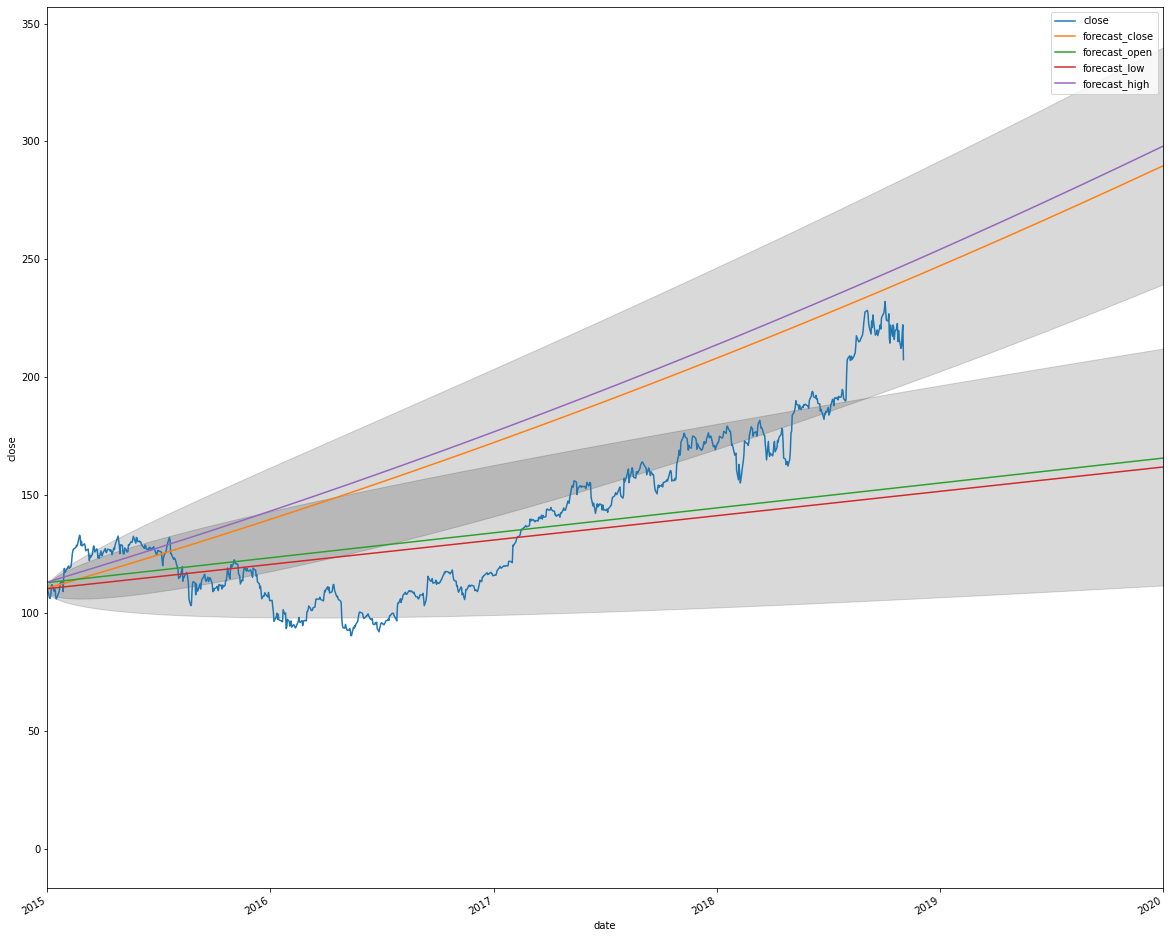

In [39]:
ax = df.plot(y='close',figsize=(20, 18))
plt.plot(fc_series_close, label='forecast_close')
plt.plot(fc_series_open, label='forecast_open')
plt.plot(fc_series_low, label='forecast_low')
plt.plot(fc_series_high, label='forecast_high')
plt.xlim(left=start_date, right=end_date)
plt.ylabel('close')
plt.fill_between(lower_series_close.index, lower_series_close, upper_series_close, 
                 color='k', alpha=.15)
plt.fill_between(lower_series_low.index, lower_series_low, upper_series_low, 
                 color='k', alpha=.15)
plt.xlabel('date')
plt.legend()
plt.show()

## Generating new Dataframe with forecast

In [44]:
frame = {'date': index, 'close':fc_series_close, 'low': fc_series_low, 'open': fc_series_open, 'high': fc_series_high}
new_df = pnd.DataFrame(frame)
new_df.set_index('date', inplace=True)
new_df.head()

,close,low,open,high
date,,,,
2015-01-01,110.434087,110.105869,112.902570,113.118919
2015-01-02,110.554168,110.291695,112.926439,113.207384
2015-01-03,110.670053,110.378514,112.953568,113.277946
2015-01-04,110.746274,110.402930,112.984946,113.352917
2015-01-05,110.820727,110.423755,113.011372,113.430821


In [45]:
def aapl_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = df.loc[:, ['close', 'open', 'high', 'low']].to_numpy()[start:end]
    return prices, signal_features


class aapl_stocks(StocksEnv):

    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


In [46]:
prices, signal_features = aapl_process_data(df=new_df, window_size=30, frame_bound=(30, len(new_df)))
env = aapl_stocks(prices, signal_features, df=new_df, frame_bound=(30, len(new_df)), window_size=6)

In [47]:
env.signal_features

array([[110.43408657, 112.90257039, 113.11891922, 110.10586871],
       [110.55416757, 112.92643858, 113.20738361, 110.29169462],
       [110.6700526 , 112.9535683 , 113.27794585, 110.37851434],
       ...,
       [289.43674318, 165.65901292, 297.76881411, 161.88210259],
       [289.5574473 , 165.68793951, 297.89351541, 161.91037679],
       [289.6781762 , 165.7168661 , 298.01824242, 161.93865099]])

In [48]:
env.action_space

Discrete(2)

In [49]:
from finta import TA

new_df['SMA'] = TA.SMA(df, 12)
new_df['RSI'] = TA.RSI(df)
new_df['OBV'] = TA.OBV(df)
new_df.fillna(0, inplace=True)
new_df.head(15)

,close,low,open,high,SMA,RSI,OBV
date,,,,,,,
2015-01-01,110.434087,110.105869,112.902570,113.118919,0.000000,0.000000,0.000000e+00
2015-01-02,110.554168,110.291695,112.926439,113.207384,111.517501,42.591853,3.880533e+10
2015-01-03,110.670053,110.378514,112.953568,113.277946,0.000000,0.000000,0.000000e+00
2015-01-04,110.746274,110.402930,112.984946,113.352917,0.000000,0.000000,0.000000e+00
2015-01-05,110.820727,110.423755,113.011372,113.430821,111.475834,36.099543,3.874105e+10
2015-01-06,110.895587,110.450588,113.042780,113.508739,111.213334,36.133590,3.880684e+10
2015-01-07,110.971200,110.479345,113.069252,113.586618,110.805000,41.162773,3.884695e+10
2015-01-08,111.046878,110.507902,113.100606,113.664557,110.814167,52.382680,3.890631e+10
2015-01-09,111.122569,110.536192,113.127132,113.742529,110.736667,52.664453,3.896001e+10


In [86]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['low','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

class aapl_custom_env(StocksEnv):
    _process_data = add_signals

env2 = aapl_custom_env(df=new_df, window_size=10, frame_bound=(10,len(new_df)))

In [87]:
env2.signal_features

array([[1.10105869e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10291695e+02, 1.11517501e+02, 4.25918531e+01, 3.88053315e+10],
       [1.10378514e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.61882103e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61910377e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61938651e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [113]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [89]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=50000)

---------------------------------
| explained_variance | 0.171    |
| fps                | 30       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.000269 |
---------------------------------
---------------------------------
| explained_variance | -3.4     |
| fps                | 789      |
| nupdates           | 100      |
| policy_entropy     | 0.693    |
| total_timesteps    | 500      |
| value_loss         | 0.00249  |
---------------------------------
---------------------------------
| explained_variance | 0.405    |
| fps                | 889      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 0.00188  |
---------------------------------
---------------------------------
| explained_variance | -0.00706 |
| fps                | 917      |
| nupdates           | 300      |
| policy_entropy     | 0.69     |
| total_timest

---------------------------------
| explained_variance | -3.89    |
| fps                | 954      |
| nupdates           | 3100     |
| policy_entropy     | 0.672    |
| total_timesteps    | 15500    |
| value_loss         | 0.00189  |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 954      |
| nupdates           | 3200     |
| policy_entropy     | 0.689    |
| total_timesteps    | 16000    |
| value_loss         | 0.0272   |
---------------------------------
---------------------------------
| explained_variance | 0.0754   |
| fps                | 954      |
| nupdates           | 3300     |
| policy_entropy     | 0.688    |
| total_timesteps    | 16500    |
| value_loss         | 0.000647 |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 954      |
| nupdates           | 3400     |
| policy_entropy     | 0.689    |
| total_timest

---------------------------------
| explained_variance | 0.0305   |
| fps                | 939      |
| nupdates           | 6200     |
| policy_entropy     | 0.684    |
| total_timesteps    | 31000    |
| value_loss         | 0.00156  |
---------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 937      |
| nupdates           | 6300     |
| policy_entropy     | 0.69     |
| total_timesteps    | 31500    |
| value_loss         | 0.00242  |
---------------------------------
---------------------------------
| explained_variance | -0.0522  |
| fps                | 936      |
| nupdates           | 6400     |
| policy_entropy     | 0.691    |
| total_timesteps    | 32000    |
| value_loss         | 0.00048  |
---------------------------------
---------------------------------
| explained_variance | 0.0693   |
| fps                | 936      |
| nupdates           | 6500     |
| policy_entropy     | 0.68     |
| total_timest

---------------------------------
| explained_variance | -2.41    |
| fps                | 929      |
| nupdates           | 9300     |
| policy_entropy     | 0.69     |
| total_timesteps    | 46500    |
| value_loss         | 0.000323 |
---------------------------------
---------------------------------
| explained_variance | 0.762    |
| fps                | 929      |
| nupdates           | 9400     |
| policy_entropy     | 0.691    |
| total_timesteps    | 47000    |
| value_loss         | 0.00333  |
---------------------------------
---------------------------------
| explained_variance | -0.324   |
| fps                | 928      |
| nupdates           | 9500     |
| policy_entropy     | 0.692    |
| total_timesteps    | 47500    |
| value_loss         | 0.000272 |
---------------------------------
---------------------------------
| explained_variance | -0.528   |
| fps                | 928      |
| nupdates           | 9600     |
| policy_entropy     | 0.685    |
| total_timest

In [147]:
env = aapl_custom_env(df=new_df, window_size=10, frame_bound=(10,len(new_df)))
obs = env.reset()

# obs_first = obs[np.newaxis, ...] 
# action, _states = model.predict(obs_first)
# obs, rewards, done, info = env.step(action)
# print(obs, done)
# obs_second = obs[np.newaxis, ...]
# action, _states = model.predict(obs_second)
# obs, rewards, done, info = env.step(action)
# print(obs)
# print('info', info)
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print('info', info)
        break

info {'total_reward': 32.65670059646125, 'total_profit': 0.002181271875831149, 'position': 1}


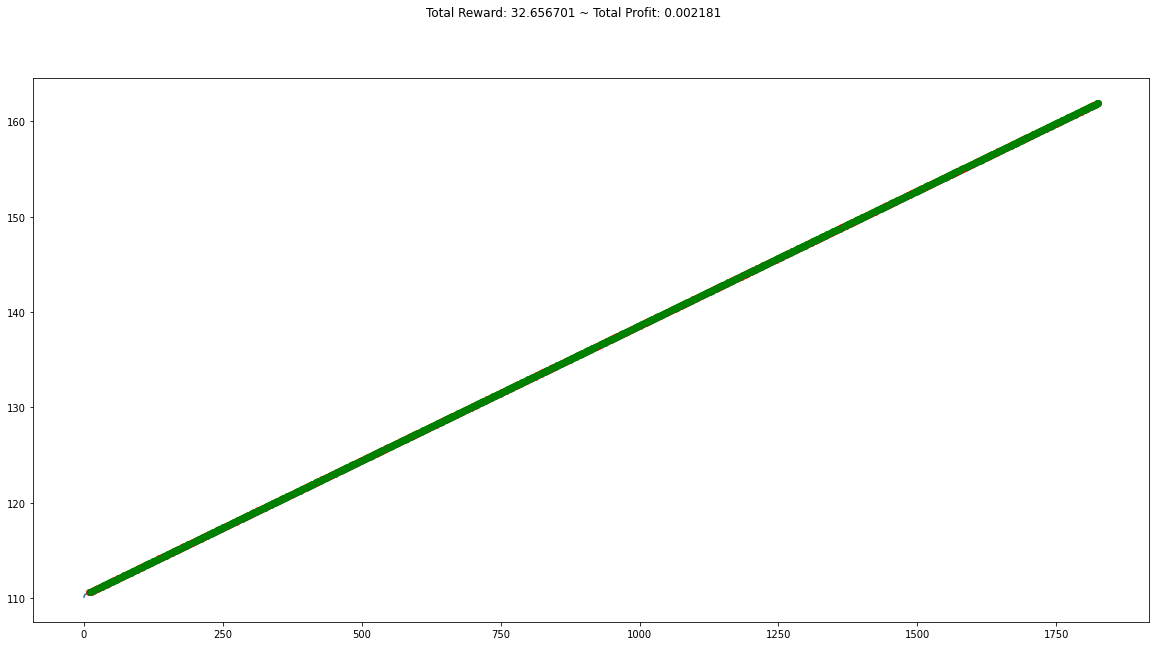

In [148]:
plt.figure(figsize=(20,10))
plt.cla()
env.render_all()
plt.show()